In [1]:
import torchvision
import torchvision.transforms as transforms

#Define transformations
transform = transforms.Compose([transforms.ToTensor()])

#Load training data
train_dataset=torchvision.datasets.FashionMNIST(
    root='/data',train=True,download=True,transform=transform
)

#Load testing data
test_dataset=torchvision.datasets.FashionMNIST(
    root='/data',train=False,download=True,transform=transform
)
print("FashionMNIST dataset loaded successfully!")

100%|██████████| 26.4M/26.4M [00:01<00:00, 20.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 302kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.63MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.5MB/s]

FashionMNIST dataset loaded successfully!


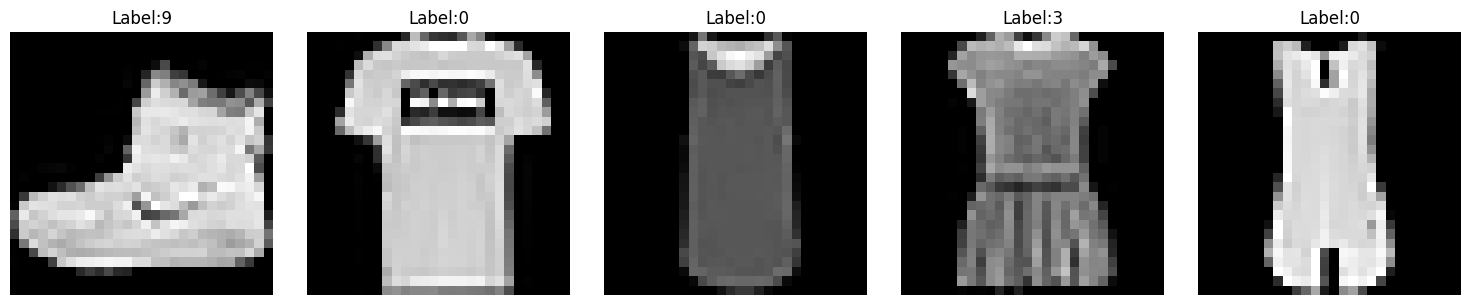

In [2]:
import matplotlib.pyplot as plt
import torch
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=1,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
plt.figure(figsize=(15,3))

for i,(image,label) in enumerate(train_dataset):
    if i<5:
        plt.subplot(1,5,i+1)
        plt.imshow(image[0].squeeze(),cmap='gray')
        plt.title(f"Label:{label}")
        plt.axis('off')
    else:
        break

plt.tight_layout()
plt.show()


In [3]:
#MLP with input 784(28*28 flattened image),one hidden layer with 128 neurons and ReLU,output layer with 10 classes(one fr each clothing item)
import torch.nn as nn
import torch.nn.functional as F


class FashionMNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten=nn.Flatten()
        self.fc1=nn.Linear(28*28,128)#input to hidden
        self.fc2=nn.Linear(128,10)#hidden to output

    def forward(self,x):
        x=self.flatten(x)
        x=F.relu(self.fc1(x))
        x=self.fc2(x) #x=self.fc2(F.relu(self.fc1(x)))
        return x

In [4]:
#define loss and optimizer
model =FashionMNIST_MLP().to("cuda" if torch.cuda.is_available() else "cpu")


loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)


In [5]:
#training loop
def training_model(dataloader,model,loss_fn,optimizer,epoch_losses):
    num_batches=len(dataloader)
    model.train()
    total_loss=0
    
    for batch,(X,y) in enumerate(dataloader):
        X,y=X.to(model.fc1.weight.device),y.to(model.fc1.weight.device)

        #forward pass
        pred=model(X)
        loss=loss_fn(pred,y)

        #backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss+=loss.item()   

    avg_loss=total_loss/num_batches
    epoch_losses.append(avg_loss)
       

In [6]:
#Evaluation
def test_model(dataloader,model):
    size=len(dataloader.dataset)
    correct=0
    model.eval()
    with torch.no_grad():
        for X,y in dataloader:
            X,y=X.to(model.fc1.weight.device),y.to(model.fc1.weight.device)
            pred=model(X)
            correct+=(pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=100*correct/size
    print(f"Test Accuracy {accuracy:>0.2f}%")

Epoch 1
-----model----------
Test Accuracy 83.81%
Epoch 2
-----model----------
Test Accuracy 85.20%
Epoch 3
-----model----------
Test Accuracy 86.15%


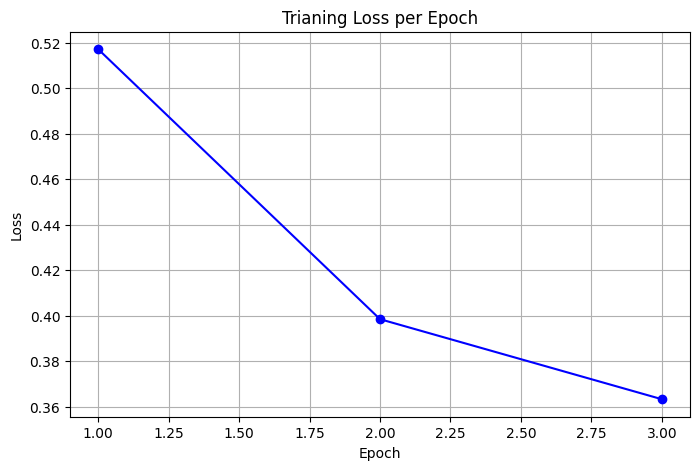

In [7]:
# train and eval for epochs
epoch_losses=[]
epochs=3
for t in range(epochs):
    print(f"Epoch {t+1}\n-----model----------")
    training_model(train_loader,model,loss_fn,optimizer,epoch_losses)
    test_model(test_loader,model)
 

#plotting loss
plt.figure(figsize=(8,5))
plt.plot(range(1,epochs+1),epoch_losses,marker='o',color='b')
plt.title("Trianing Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
 